In [2]:
#第一课 BSM 公式即通过蒙特卡洛方式模拟估计欧式看涨期权价值。


import numpy as np

import matplotlib.pyplot as plt

S0 = 100. #当前股票价格
K = 105. #行权价
T = 1.0 #一年时间
r = 0.05 #固定无风险短期一年利率
sigma = 0.2 #固定波动率 20%

I = 100000  #为随机路径个数

z = np.random.standard_normal(I)   #每天有10000个变化数值

#根据BSM(1973)公式，简单计算T时间之后的股票价格ST，有I个价格
ST = S0 * np.exp((r - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * z)
#计算到期期权的所有内在价值
hT = np.maximum(ST-K, 0)
#欧式期权的蒙特卡洛估算函数，求得期权当前的价值
C0 = np.exp(-r * T) * np.sum(hT) / I

print("value of european call option %5.3f" %(C0))




value of european call option 8.049


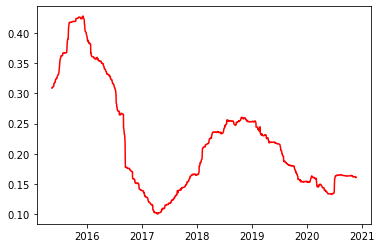

In [47]:
#第二课 一个简单的例子
#计算某个标的证券的波动率
import numpy as np
import pandas as pd
from datetime import datetime
#step1 ： 加载数据
df =pd.read_csv("./分析股票行情/601398_1d.csv")
df['date']= df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
#step2:  计算标的波动率，所谓波动率实际上是收益的标准差
df['Log_Ret']=np.log(df['close'] / df['close'].shift(1))
df['Volatility'] = df['Log_Ret'].rolling(252).std() * np.sqrt(252)

#step3:  绘制数据
%matplotlib inline
#df[['close','Volatility']].plot()

#plt.plot(df['date'],df['close'],'blue')
plt.plot(df['date'],df['Volatility'],'r')



In [52]:
# 第三课
#尽量使用库，性能高很多
from math import *
loops = 100000
a = range(1, loops)
def f(x):
    return 3*log(x) + cos(x)**2
%timeit r = [f(x) for x in a]


import numpy as np
a = np.arange(1, loops)
%timeit r = 3 *np.log(a) + np.cos(a)**2





58.2 ms ± 935 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.96 ms ± 9.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [67]:
#第四课
#隐含波动率
#根据BSM(1973)定价公式
#这个只是用于学习的，和我们实际用到的不大一样的。
from math import log, sqrt, exp
from scipy import stats

def bsm_call_value(S0, K, T, r, sigma):
    '''valuation of European call option in BSM model.
    Parameters
    =========
    S0 : float
        underlying instrument price 
    K: float
        strike price
    T: float
        from now to maturity date ( in year fractions)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term
    
    Returns
    =========
    value: float
        present value of the European call option
    '''
    S0 = float(S0)
    d1 = (log(S0/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0/K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) \
            - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value


def bsm_vega(S0, K, T, r, sigma):
    ''' vega of european option in BSM model
    Parameters
    =========
    S0 : float
            underlying instrument price
    K: float
            strike price
    T: float
            from now to maturity date ( in year fractions)
    r: float
            constant risk-free short rate
    sigma: float
            volatility factor in diffusion term
        
    Returns
    =========
    vega: float
        partial derivative of BSM formula with respect to sigma 
    '''

    S0 = float(S0)
    d1 = (log(S0/K) + (r + 0.5 * sigma ** 2) * T / (sigma * sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    '''
    Parameters
    ==========
    S0 : float
            underlying instrument price
    K: float
            strike price
    T: float
            from now to maturity date ( in year fractions)
    r: float
            constant risk-free short rate
    sigma_est: float
           estimate of impl. volatility
    it: integer
            number of iterations

    Returns
    ==========
    sigma_est : float
    '''
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K,T,r,sigma_est))
    return sigma_est


S0=100
K=105
T=1
r=0.05
underlying_v=0.2
C0=5


v1=bsm_call_value(S0,K,T,r,underlying_v)
v2=bsm_vega(S0,K,T,r,underlying_v)   #这个值和我们当前工作计算中的值不一样。
v3=bsm_call_imp_vol(S0,K,T,r,C0,0.1,100)
print("theoPrice=%f %f %f"%(v1,v2,v3))






    


theoPrice=8.021352 61.837275 0.123964


In [74]:
#第五课
# 纯python 进行欧式看涨期权的蒙特卡洛估值
# 在第一节课中也有，
#    只是第一节课中时间只有一步，而这里时间细分成了M步，可以理解为每步价格都会计算，比如日天数。
#    如下此时，M取1就接近第一课中的值，M取值越大，约消耗计算，这是个衡量。

from time import time
from math import exp, sqrt, log
from random import gauss, seed

seed(2000)
t0 = time()

S0 = 100.0
K = 105.0
T = 1.0
r = 0.05
sigma = 0.2
M = 50 # number of time steps
dt = T / M  # length of time interval
I = 25*10000

# Simulating I paths with M time steps
S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.0)
            St = path[t - 1] * exp((r - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) *z)
            path.append(St)
    S.append(path)

# Calculating the monte carlo estimator
C0 = exp(-r * T) * sum([max(path[-1] -K,0) for path in S]) / I

#Results output
tpy = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in Seconds %7.3f" % tpy)












European Option Value   8.011
Duration in Seconds  20.853


In [99]:
#第六节课 
# Numpy方式python 进行欧式看涨期权的蒙特卡洛估值
# 时间上，比第六课纯Python相比，时间为0.657，而纯python为20.853秒。

import numpy as np
import math
from time import time

np.random.seed(2000)
t0 = time()

S0 = 100.0
K = 105.0
T = 1.0
r = 0.05
sigma = 0.2
M = 50 # number of time steps
dt = T / M  # length of time interval
I = 25*10000

# Simulating I paths with M time steps
S = np.zeros((M+1,I))
S[0]=S0

for t in range(1,M+1):
    z = np.random.standard_normal(I)   # 一次性生成I个数据
    S[t] = S[t-1]* np.exp((r - 0.5*sigma **2)*dt + sigma * math.sqrt(dt) * z)  #一步生成I条路径的第t天数据
print(z.shape) # I 个
C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1]-K,0)) / I

# Results output
tnp1 = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in Seconds   %7.3f" % tnp1)




(250000,)
European Option Value   8.018
Duration in Seconds     0.657


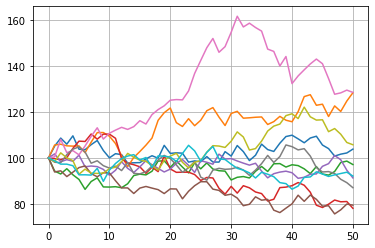

In [102]:
#第七课 1 
#画图，输出前10条路径所有时间step的数据
import matplotlib.pyplot as plt
plt.plot(S[:,:10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')


Text(0, 0.5, 'frequency')

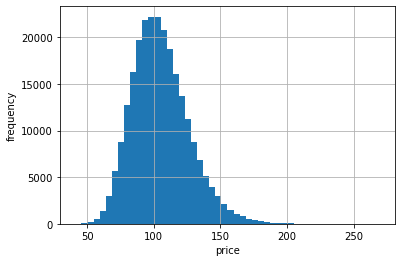

In [105]:
#第七课 2
#输出最后一天的所有路径的价格分布图
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('price')
plt.ylabel('frequency')


(0.0, 50000.0)

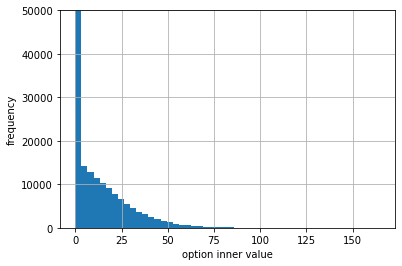

In [106]:
#第七课 3
#期权期末内在价值的图

plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)




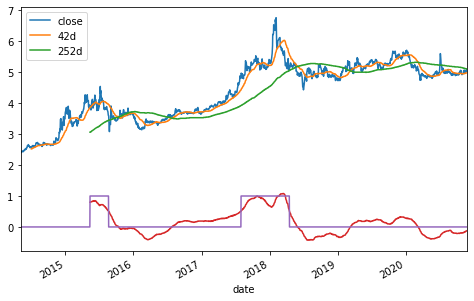

In [146]:
#第八课 
#接下来开始 技术分析,一个简单的例子，结果不重要，只是一个初步了解
import numpy as np
import pandas as pd
from datetime import datetime
#step1 ： 加载数据
df =pd.read_csv("./分析股票行情/601398_1d.csv")
df['date']= df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
#将时间列作为index
df.index = df['date']


#移动42天平均数，精确到小数点2位
df['42d'] = np.round(df['close'].rolling(42).mean(), 2)

df['252d'] = np.round(df['close'].rolling(252).mean(), 2)

df[['close','42d','252d']].plot(grid=True, figsize=(8, 5))

#计算42天和252天的移动平均数差值
df['42-252'] = df['42d'] - df['252d']
df['42-252'].plot()

#设定阈值SD
#假设0.5
SD1= 0.5
SD2= -0.5

#将大于SD的值，标志为1，小于标志为-1，等于标志为0，这样可以方便指导比率
df['regime'] = np.where(df['42-252']>SD1,1,0)
df['regime'] = np.where(df['42-252']<SD2,-1,df['regime'])
df['regime'].value_counts()
df[df['regime']==0].tail()
#假设短期趋势交叉长期趋势，则一段时间内，都会保持这个趋势，这就是投资体制(regime)
#通过图像可以看到，将原先波浪图变成了类似直方图，这个有点类似与滤波的感觉，也类似于电子电路专业中的模数转换。
df['regime'].plot()
#

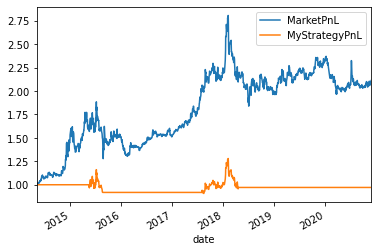

In [147]:
#计算每天的对数收益率
df['MarketPnL']=np.log(df['close'] / df['close'].shift(1))
#如果昨天的regime是做多，则收益是今天的market收益
df['MyStrategyPnL'] = df['regime'].shift(1) * df['MarketPnL']
#观察图，可以看到根据这个策略，交易机会不多
df[['MarketPnL','MyStrategyPnL']].cumsum().apply(np.exp).plot()

Text(0.5, 1.0, 'plot sample')

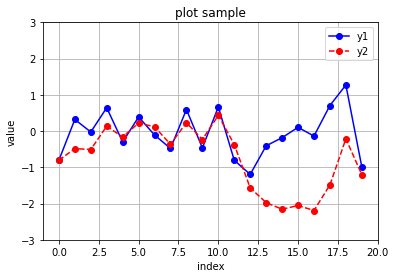

In [178]:
#第九课 
# 简单画图，跟之前用到的库相同，但是用法不一样
np.random.seed(1000)
y = np.random.standard_normal(20)
x = range(len(y))
y3 = y*100
plt.plot(x,y,'bo-',label='y1')
plt.plot(y.cumsum(),color='red',marker='o',linestyle='--',label='y2')
plt.legend(loc=0)
plt.grid(True)
plt.axis('tight')  #tight 使得所有数据可先   ,off关闭坐标轴和网格
plt.xlim(-1,20)  #横坐标范围
plt.ylim(-3,3)   #纵坐标范围
plt.xlabel('index')
plt.ylabel('value')
plt.title('plot sample')


Text(0, 0.5, 'value y2')

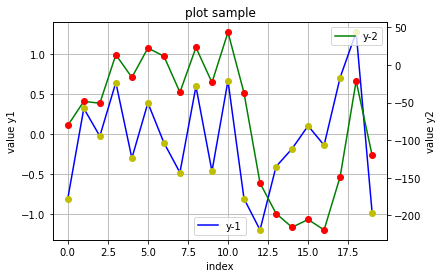

In [193]:
#第九课 两个y轴

fig, ax1 = plt.subplots()

np.random.seed(1000)
y = np.random.standard_normal(20)
x = range(len(y))
y2 = y*100
plt.plot(y,'b',lw=1.5,label='y-1')
plt.plot(y,'yo')
plt.grid(True)
plt.legend(loc=8)

plt.axis('tight')  #tight 使得所有数据可先   ,off关闭坐标轴和网格
plt.xlabel('index')
plt.ylabel('value y1')
plt.title('plot sample')
ax2 = ax1.twinx()
plt.plot(y2.cumsum(),'g',lw=1.5,label='y-2')
plt.plot(y2.cumsum(),'ro')
plt.legend(loc=0)
plt.ylabel('value y2')



Text(0, 0.5, 'value')

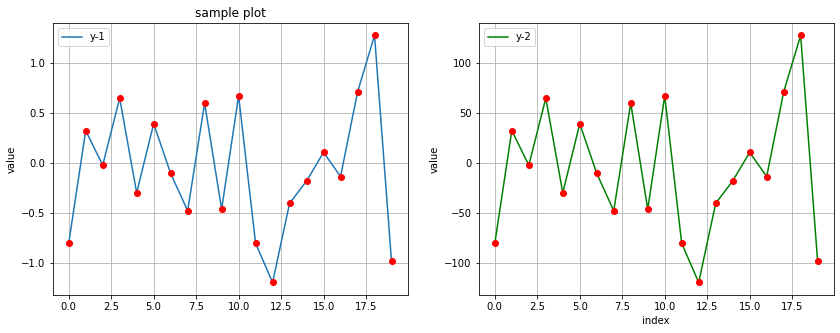

In [202]:
#上面是一张图，两根坐标轴
#下面是两张图，每张图一根坐标轴
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(y,lw=1.5,label='y-1')
plt.plot(y,'ro')
plt.grid(True)
plt.legend(loc=0)
plt.axis('tight')
plt.ylabel('value')
plt.title('sample plot')

plt.subplot(1,2,2)
plt.plot(y2,'g',lw=1.5,label='y-2')
plt.plot(y2,'ro')
plt.grid(True)
plt.legend(loc=0)
plt.axis('tight')
plt.xlabel('index')
plt.ylabel('value')

In [297]:
# 第十课 
# pandas进行date_range
# pickle进行二进制序列化
a = np.random.standard_normal((9,4))
a.round(6) #保留6位小数

df1 = pd.DataFrame(a)
df1.columns = [ 'No1','No2','No3','No4' ]

#自动生成时间序列
datas = pd.date_range('2021-1-1',periods=9, freq='M')
df1.index = datas

del df1['No1']
df1.describe()

#对象二进制序列化写入数据
a = [ gauss(1.5,2) for i in range(1000000)]
import pickle
pkl_file = open("./data.pkl",'bw')
%time pickle.dump(a, pkl_file)
pkl_file.close()
#对象二进制序列化读取数据
pkl_file1 = open("./data.pkl",'br')
%time b = pickle.load(pkl_file1)

#比较两个对象是否一致
np.allclose(np.array(a), np.array(b))

#等于0 也是一种比较对象值的方式
np.sum(np.array(a)-np.array(b))













Wall time: 36.1 ms
Wall time: 83 ms


0.0

In [299]:
#第十一课
# csv格式读写
rows = 5000
a = np.random.standard_normal((rows,5))
a.round(4)
t = pd.date_range(start='2018-1-1', periods=rows, freq='H')
csv_file = open("./data.csv",'w')
header = 'data,no1,no2,no3,no4,no5\n'
csv_file.write(header)
for t_, (no1, no2, no3, no4, no5) in zip(t, a):
    s = '%s,%f,%f,%f,%f,%f\n' %(t_, no1,no2,no3,no4,no5)
    csv_file.write(s)
csv_file.close()

csv_file = open("./data.csv",'r')
for i in range(5):
    print(csv_file.readline())
csv_file.close()




data,no1,no2,no3,no4,no5

2018-01-01 00:00:00,0.896570,-0.916095,1.016006,-0.076773,1.172085

2018-01-01 01:00:00,-0.118885,-0.586541,-0.700655,-0.891606,-0.942663

2018-01-01 02:00:00,1.789539,0.729734,-0.071046,-1.284591,1.565903

2018-01-01 03:00:00,0.239564,1.468773,-1.668009,0.533261,0.650014



In [5]:
# 第十二课
# 并行计算
def bsm_msc_valuation(strike):
    S0 = 100.; T=1.; r=0.05; vola=0.2; M=50; I=20000; dt=T/M; 
    rand = np.random.standard_normal((M+1, I))
    S=np.zeros((M+1, I))
    S[0] = S0
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r - 0.5 * vola**2)*dt + vola*np.sqrt(dt)*rand[t])
    value = (np.exp(-r * T) * np.sum(np.maximum(S[-1]- strike, 0))/I)
    return value

def seq_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_msc_valuation(strike))
    return strikes, option_values

n = 10
%time strikes, option_values_seq = seq_value(n)

Wall time: 404 ms


In [6]:
def par_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_msc_valuation(strike))
    return strikes, option_values


from numpy import *
t=linspace(0,10,10000)
x=sin(t)

def newsin(i):
    t=linspace(i,i+1,1000)
    return sin(t)

from multiprocessing import Pool # 导入多进程中的进程池
def newsin(i):
    t=linspace(i,i+1,1000)
    return sin(t)

p=Pool(10) #创建含有十个10个进程的进程池
results=[] #存放每一个进程返回的结果
for i in range(10): # 启动10个进程
    r=p.apply_async(newsin,args=(i,)) # 产生一个非同步进程，函数newsin的参数用args传递
    results.append(r) # 将返回结果放入results
p.close() #关闭进程池
p.join()  #结束


In [1]:
from multiprocessing import Pool # 导入多进程中的进程池
import time
def foo_pool(x):
    time.sleep(2)
    return x*x

def log_result(x):
    print(x)

if __name__ == "__main__":
    pool = Pool(6)
    for i in range(6):
        pool.apply_async(foo_pool,args=(i,),callback= log_result)
    pool.close()
    pool.join()
